'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Hidden Markov Models (HMM)

The hidden Markov model (HMM) can be viewed as a specific instance of the state space model shown in Figure 13.5, where the latent variables are discrete. Examining a single time slice of the model reveals that it corresponds to a mixture distribution, with component densities given by $p(x|z)$. Hence, HMMs can also be interpreted as an extension of a mixture model, where the choice of the mixture component for each observation depends on the choice of the component for the previous observation.

HMMs are widely used in:

- Speech recognition ([Jelinek, 1997]
- Natural language modeling ([Manning and Schütze, 1999]
- Online handwriting recognition ([Nag et al., 1986]
- Analysis of biological sequences like proteins and DNA ([Krogh et al., 1994]


![image.png](attachment:image.png)

Fig.6 Transition diagram showing a model whose latent variables have three possible states corresponding to the three boxes. The black lines denote the elements of the transition matrix $A_jk$ .


### Latent Variables and Transition Probabilities

The latent variables in HMMs are discrete multinomial variables $z_n$, which describe the component responsible for generating the corresponding observation $x_n$. Using a 1-of-$K$ coding scheme, we denote the conditional distribution of $z_n$ given $z_{n-1}$ by:

$$
p(z_n | z_{n-1}, A) = \prod_{k=1}^K \prod_{j=1}^K A_{jk}^{z_{n-1,j} z_{n,k}},
$$

where $A_{jk}$ represents the transition probabilities:

$$
A_{jk} = p(z_{n,k} = 1 | z_{n-1,j} = 1), \quad \text{with } 0 \leq A_{jk} \leq 1 \text{ and } \sum_{k=1}^K A_{jk} = 1.
$$

The initial latent variable $z_1$ is special since it lacks a parent node. Its marginal distribution is represented by:

$$
p(z_1 | \pi) = \prod_{k=1}^K \pi_k^{z_{1,k}}, \quad \text{with } \sum_{k=1}^K \pi_k = 1.
$$

### State Transition Diagram

The transition matrix $A$ can be illustrated using a state transition diagram. For $K = 3$, this is shown below:

```
State Transition Diagram:
  A_{11} A_{12} A_{13}
    |     |     |
   [S1]--[S2]--[S3]
  A_{21} A_{22} A_{23}
```

Unfolding the diagram over time yields a **lattice** or **trellis** diagram:

![image-2.png](attachment:image-2.png)

Fig.7 If we unfold the state transition dia- gram of Fig.6 over time, we obtain a lattice, or trellis, representation of the latent states. Each column of this diagram corresponds to one of the latent variables $z_n$ .

```
Trellis Diagram:
  n-2    n-1     n     n+1
  [S1]--[S1]--[S1]--[S1]
  [S2]--[S2]--[S2]--[S2]
  [S3]--[S3]--[S3]--[S3]
```

### Emission Probabilities

The conditional distribution of observed variables $p(x_n | z_n, \phi)$ defines the emission probabilities, where $\phi$ is a set of parameters governing the distribution. These probabilities might be:

- **Gaussian** for continuous $x$
- **Conditional probability tables** for discrete $x$

The emission probabilities are given by:

$$
p(x_n | z_n, \phi) = \prod_{k=1}^K p(x_n | \phi_k)^{z_{n,k}}.
$$

### Joint Probability Distribution

The joint probability over both latent and observed variables is:

$$
p(X, Z | \theta) = p(z_1 | \pi) \prod_{n=2}^N p(z_n | z_{n-1}, A) \prod_{m=1}^N p(x_m | z_m, \phi),
$$

where:

- $X = \{x_1, \ldots, x_N\}$ are the observations.
- $Z = \{z_1, \ldots, z_N\}$ are the latent variables.
- $\theta = \{\pi, A, \phi\}$ is the set of parameters.

### Generative Process for HMMs

To generate a sample from an HMM:

1. **Initialize**: Draw the initial state $z_1$ from $p(z_1 | \pi)$.
2. **Transition**: For each $n \geq 2$, draw $z_n$ from $p(z_n | z_{n-1}, A)$.
3. **Emit**: For each $n$, draw $x_n$ from $p(x_n | z_n, \phi)$.


In [2]:
class HiddenMarkovModel:
    def __init__(self, states, observations, transition_prob, emission_prob, initial_prob):
        """
        states: List of hidden states (e.g., ['Rainy', 'Sunny'])
        observations: List of possible observations (e.g., ['Walk', 'Shop', 'Clean'])
        transition_prob: Transition probabilities (A matrix as a dictionary)
        emission_prob: Emission probabilities (B matrix as a dictionary)
        initial_prob: Initial probabilities (pi vector as a dictionary)
        """
        self.states = states
        self.observations = observations
        self.transition_prob = transition_prob
        self.emission_prob = emission_prob
        self.initial_prob = initial_prob

    def generate_sequence(self, length):
        """Generate a sequence of states and observations."""
        import random

        # Generate initial state
        state = random.choices(self.states, weights=[self.initial_prob[s] for s in self.states])[0]
        states = [state]

        # Generate initial observation
        observation = random.choices(
            self.observations, weights=[self.emission_prob[state][o] for o in self.observations]
        )[0]
        observations = [observation]

        # Generate subsequent states and observations
        for _ in range(1, length):
            # Transition to next state
            state = random.choices(self.states, weights=[self.transition_prob[states[-1]][s] for s in self.states])[0]
            states.append(state)

            # Emit an observation
            observation = random.choices(
                self.observations, weights=[self.emission_prob[state][o] for o in self.observations]
            )[0]
            observations.append(observation)

        return states, observations

    def forward_algorithm(self, obs_sequence):
        """
        Perform the forward algorithm to calculate the probability of an observation sequence.
        obs_sequence: List of observations (e.g., ['Walk', 'Shop', 'Clean'])
        """
        alpha = [{} for _ in range(len(obs_sequence))]  # Alpha values

        # Initialization
        for state in self.states:
            alpha[0][state] = self.initial_prob[state] * self.emission_prob[state][obs_sequence[0]]

        # Induction
        for t in range(1, len(obs_sequence)):
            for state in self.states:
                alpha[t][state] = sum(
                    alpha[t - 1][prev_state] * self.transition_prob[prev_state][state]
                    for prev_state in self.states
                ) * self.emission_prob[state][obs_sequence[t]]

        # Termination
        return sum(alpha[-1][state] for state in self.states)

# Example usage
states = ['Rainy', 'Sunny']
observations = ['Walk', 'Shop', 'Clean']

transition_prob = {
    'Rainy': {'Rainy': 0.7, 'Sunny': 0.3},
    'Sunny': {'Rainy': 0.4, 'Sunny': 0.6},
}

emission_prob = {
    'Rainy': {'Walk': 0.1, 'Shop': 0.4, 'Clean': 0.5},
    'Sunny': {'Walk': 0.6, 'Shop': 0.3, 'Clean': 0.1},
}

initial_prob = {
    'Rainy': 0.6,
    'Sunny': 0.4,
}

# Initialize HMM
hmm = HiddenMarkovModel(states, observations, transition_prob, emission_prob, initial_prob)

# Generate a sequence
generated_states, generated_observations = hmm.generate_sequence(10)
print("Generated States:", generated_states)
print("Generated Observations:", generated_observations)

# Forward algorithm
obs_sequence = ['Walk', 'Shop', 'Clean']
probability = hmm.forward_algorithm(obs_sequence)
print("Probability of observation sequence:", probability)


Generated States: ['Rainy', 'Rainy', 'Rainy', 'Rainy', 'Sunny', 'Rainy', 'Sunny', 'Sunny', 'Sunny', 'Sunny']
Generated Observations: ['Shop', 'Shop', 'Clean', 'Shop', 'Walk', 'Shop', 'Shop', 'Walk', 'Walk', 'Walk']
Probability of observation sequence: 0.033612


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a HiddenMarkovModel instance
states = ['Sunny', 'Rainy', 'Cloudy']
observations = ['Walk', 'Shop', 'Clean']
start_probs = [0.5, 0.3, 0.2]
transition_matrix = [
    [0.6, 0.3, 0.1],
    [0.4, 0.4, 0.2],
    [0.3, 0.3, 0.4]
]
emission_matrix = [
    [0.5, 0.4, 0.1],
    [0.1, 0.3, 0.6],
    [0.3, 0.4, 0.3]
]

hmm = HiddenMarkovModel(states, observations, start_probs, transition_matrix, emission_matrix)

# Generate a sequence of states and observations
hidden_states, observed_sequence = hmm.generate_sequence(10)

# Plot the sequences
plt.figure(figsize=(10, 4))
plt.plot(range(len(hidden_states)), hidden_states, marker='o', label='Hidden States')
plt.plot(range(len(observed_sequence)), observed_sequence, marker='x', label='Observations')
plt.yticks(range(len(states)), states)
plt.xticks(range(len(hidden_states)))
plt.xlabel('Time Step')
plt.ylabel('States / Observations')
plt.legend()
plt.title('Generated Sequence of States and Observations')
plt.grid()
plt.show()

# Plot the transition matrix
plt.figure(figsize=(6, 5))
sns.heatmap(transition_matrix, annot=True, xticklabels=states, yticklabels=states, cmap="Blues")
plt.title('Transition Matrix')
plt.xlabel('Next State')
plt.ylabel('Current State')
plt.show()

# Plot the emission matrix
plt.figure(figsize=(6, 5))
sns.heatmap(emission_matrix, annot=True, xticklabels=observations, yticklabels=states, cmap="Greens")
plt.title('Emission Matrix')
plt.xlabel('Observation')
plt.ylabel('State')
plt.show()


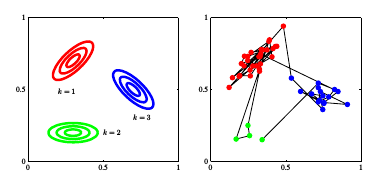

Fig.8 Illustration of sampling from a hidden Markov model having a 3-state latent variable z and a Gaussian emission model p(x|z) where x is 2-dimensional. (a) Contours of constant probability density for the emission distributions corresponding to each of the three states of the latent variable. (b) A sample of 50 points drawn from the hidden Markov model, colour coded according to the component that generated them and with lines connecting the successive observations. Here the transition matrix was ﬁxed so that in any state there is a 5% probability of making a transition to each of the other states, and consequently a 90% probability of remaining in the same state.

## Hidden Markov Model (HMM) with Gaussian Emissions

### Overview
A hidden Markov model (HMM) is a statistical model where the system being modeled is assumed to be a Markov process with unobservable (hidden) states. The observed data is generated based on these hidden states. In this notebook, we describe the HMM with Gaussian emissions and illustrate its generative process.

### Generative Process for an HMM
An HMM consists of:
- **Latent variables** $z_t$: These represent the hidden states at each time step $t$.
- **Observations** $x_t$: These are the observed values generated from the hidden states.
- **Parameters**:
  - Transition matrix $A = \{A_{jk}\}$, where $A_{jk} = P(z_t = k | z_{t-1} = j)$.
  - Initial state probabilities $\pi = \{\pi_k\}$, where $\pi_k = P(z_1 = k)$.
  - Emission distributions $P(x_t | z_t = k)$: For Gaussian emissions, this is $\mathcal{N}(\mu_k, \Sigma_k)$.

### Steps to Generate Data
1. Sample the initial hidden state $z_1$ from the initial distribution $\pi$.
2. For each time step $t$:
   - Sample $z_t$ from the transition distribution $P(z_t | z_{t-1})$.
   - Sample $x_t$ from the emission distribution $P(x_t | z_t)$.

### Key Equations
- Transition probability:
  $$
  P(z_t | z_{t-1}, A) = \prod_{k=1}^K \prod_{j=1}^K A_{jk}^{z_{t-1,j} z_{t,k}}
  $$

- Emission probability for Gaussian emissions:
  $$
  P(x_t | z_t = k, \mu_k, \Sigma_k) = \mathcal{N}(x_t; \mu_k, \Sigma_k)
  $$

- Joint probability of observations and latent states:
  $$
  P(X, Z | \theta) = P(z_1 | \pi) \prod_{t=2}^N P(z_t | z_{t-1}, A) \prod_{t=1}^N P(x_t | z_t, \phi),
  $$
  where $\theta = \{\pi, A, \phi\}$.

### Visual Illustration
- **State Transition Matrix**: $A$ governs the transitions between latent states. Large diagonal elements $A_{kk}$ indicate a higher probability of staying in the same state.
- **Emission Distributions**: Define how observations $x_t$ are generated from the latent states $z_t4.

---

### Example: Sampling from a 3-State HMM with Gaussian Emissions

1. **Emission Distributions**:
    - Each hidden state generates observations $x_t$ from a distinct Gaussian distribution. For simplicity, we assume $x_t \in \mathbb{R}^2$.
    
    $$
    P(x | z=k) = \mathcal{N}(x; \mu_k, \Sigma_k),
    $$
    where $\mu_k$ and $\Sigma_k$ are the mean and covariance of the Gaussian.

2. **Transition Matrix**:
    - Transition matrix $A$ with elements $A_{jk} = P(z_t = k | z_{t-1} = j)$. 
    - Example: $A$ has a 90% probability of staying in the current state and a 5% probability of transitioning to each of the other two states.

3. **Generative Illustration**:
    - Figure (a): Contours of the Gaussian emission distributions for the three states.
    - Figure (b): A sequence of 50 observations drawn from the HMM, color-coded by the state that generated them.

---

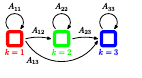

Fig.9 Example of the state transition diagram for a 3-state left-to-right hidden Markov model. Note that once a state has been vacated, it cannot later be re-entered.

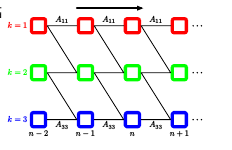

Fig.10 Lattice diagram for a 3-state left- to-right HMM in which the state index k is allowed to increase by at most 1 at each transition.

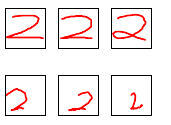

Fig.11 Top row: examples of on-line handwritten digits. Bottom row: synthetic digits sam-pled generatively from a left-to-right hid- den Markov model that has been trained on a data set of 45 handwritten digits.

### Code Implementation
Below is Python code for generating samples from an HMM and visualizing the results.



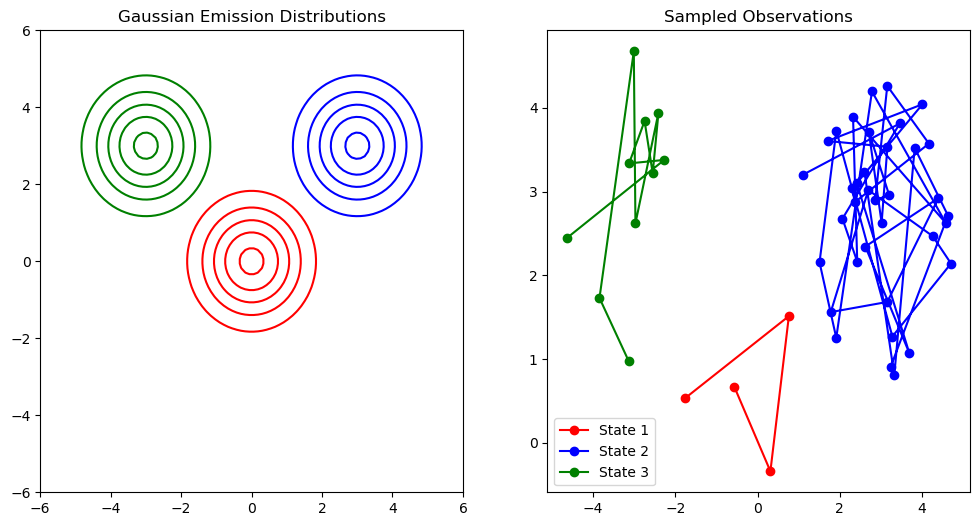

In [4]:
#```python
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Parameters for the HMM
K = 3  # Number of hidden states
pi = np.array([0.4, 0.4, 0.2])  # Initial probabilities
A = np.array([
    [0.9, 0.05, 0.05],
    [0.05, 0.9, 0.05],
    [0.05, 0.05, 0.9]
])
means = [np.array([0, 0]), np.array([3, 3]), np.array([-3, 3])]
covs = [np.eye(2), np.eye(2), np.eye(2)]

# Sampling from the HMM
def sample_hmm(pi, A, means, covs, T):
    """Generate samples from an HMM."""
    K = len(pi)
    z = np.zeros(T, dtype=int)
    x = np.zeros((T, 2))

    # Sample initial state
    z[0] = np.random.choice(K, p=pi)
    x[0] = multivariate_normal.rvs(mean=means[z[0]], cov=covs[z[0]])

    # Sample subsequent states and observations
    for t in range(1, T):
        z[t] = np.random.choice(K, p=A[z[t-1]])
        x[t] = multivariate_normal.rvs(mean=means[z[t]], cov=covs[z[t]])

    return z, x

# Generate samples
T = 50
z_samples, x_samples = sample_hmm(pi, A, means, covs, T)

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# (a) Gaussian contours
colors = ['red', 'blue', 'green']
for k in range(K):
    rv = multivariate_normal(mean=means[k], cov=covs[k])
    x, y = np.meshgrid(np.linspace(-6, 6, 100), np.linspace(-6, 6, 100))
    pos = np.dstack((x, y))
    ax[0].contour(x, y, rv.pdf(pos), colors=colors[k], levels=5)
ax[0].set_title("Gaussian Emission Distributions")
ax[0].set_xlim([-6, 6])
ax[0].set_ylim([-6, 6])

# (b) Sampled observations
for k in range(K):
    state_indices = np.where(z_samples == k)[0]
    ax[1].plot(x_samples[state_indices, 0], x_samples[state_indices, 1], 'o-', color=colors[k], label=f"State {k+1}")
ax[1].set_title("Sampled Observations")
ax[1].legend()

plt.show()



In [5]:
import random
import math

# Define the HMM parameters
states = [0, 1, 2]  # Three latent states
pi = [0.33, 0.33, 0.34]  # Initial state probabilities
transition_matrix = [
    [0.9, 0.05, 0.05],
    [0.05, 0.9, 0.05],
    [0.05, 0.05, 0.9]
]  # Transition probabilities

# Emission model: Gaussian parameters (mean, stddev) for each state
emission_params = {
    0: ([1, 1], [0.5, 0.5]),  # State 0: Mean (1,1), Stddev (0.5, 0.5)
    1: ([3, 3], [0.5, 0.5]),  # State 1: Mean (3,3), Stddev (0.5, 0.5)
    2: ([5, 1], [0.5, 0.5])   # State 2: Mean (5,1), Stddev (0.5, 0.5)
}

# Sampling functions
def sample_categorical(probabilities):
    """Sample from a categorical distribution."""
    rand = random.random()
    cumulative = 0
    for i, prob in enumerate(probabilities):
        cumulative += prob
        if rand < cumulative:
            return i

def sample_gaussian(mean, stddev):
    """Generate a sample from a Gaussian distribution."""
    return [random.gauss(m, s) for m, s in zip(mean, stddev)]

# HMM Sampling
def sample_hmm(pi, transition_matrix, emission_params, n_samples):
    """Generate samples from an HMM."""
    states_sequence = []
    emissions_sequence = []

    # Initial state
    current_state = sample_categorical(pi)
    states_sequence.append(current_state)

    # Generate emission for the initial state
    mean, stddev = emission_params[current_state]
    emissions_sequence.append(sample_gaussian(mean, stddev))

    # Generate subsequent states and emissions
    for _ in range(1, n_samples):
        # Transition to next state
        current_state = sample_categorical(transition_matrix[current_state])
        states_sequence.append(current_state)

        # Generate emission for the current state
        mean, stddev = emission_params[current_state]
        emissions_sequence.append(sample_gaussian(mean, stddev))

    return states_sequence, emissions_sequence

# Generate samples
n_samples = 50
states_sequence, emissions_sequence = sample_hmm(pi, transition_matrix, emission_params, n_samples)

# Visualization
def plot_hmm_samples(states_sequence, emissions_sequence):
    """Plot the samples from the HMM."""
    print("States Sequence:")
    print(states_sequence)
    print("\nEmissions Sequence:")
    for e in emissions_sequence:
        print(f"({e[0]:.2f}, {e[1]:.2f})")

    # Prepare plot
    x_coords = [e[0] for e in emissions_sequence]
    y_coords = [e[1] for e in emissions_sequence]

    print("\nPoints plotted with lines between consecutive emissions (state color-coded):")
    print(f"x-coordinates: {x_coords}")
    print(f"y-coordinates: {y_coords}")

# Plot results
plot_hmm_samples(states_sequence, emissions_sequence)


States Sequence:
[2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Emissions Sequence:
(5.01, 2.00)
(4.46, 1.12)
(5.22, 0.48)
(4.78, 1.55)
(4.86, 1.85)
(4.50, 1.57)
(5.18, -0.34)
(0.88, 1.28)
(1.06, 0.20)
(0.83, 0.40)
(0.81, 0.04)
(0.69, 0.60)
(1.60, -0.71)
(0.89, 0.27)
(0.94, 0.95)
(3.61, 2.47)
(2.94, 2.72)
(3.01, 2.47)
(3.36, 3.65)
(3.42, 2.80)
(2.63, 3.09)
(2.68, 3.51)
(0.42, 1.78)
(2.50, 3.53)
(2.92, 3.24)
(2.90, 3.77)
(3.49, 2.56)
(2.72, 2.99)
(2.13, 2.96)
(3.48, 3.07)
(3.27, 2.70)
(3.64, 2.68)
(3.09, 3.13)
(3.33, 2.98)
(2.88, 3.24)
(1.23, 1.23)
(0.82, 1.06)
(1.05, 1.09)
(0.48, 0.71)
(2.02, 1.59)
(1.58, 0.86)
(1.04, 1.40)
(0.67, 1.13)
(0.56, 1.07)
(1.71, 0.22)
(0.99, 1.75)
(1.65, 0.76)
(1.54, 1.48)
(1.00, 0.99)
(1.82, 0.85)

Points plotted with lines between consecutive emissions (state color-coded):
x-coordinates: [5.006240524161744, 4.460583813403585, 5.217194861608606, 4.775466

In [6]:
import turtle

# Set up the screen
screen = turtle.Screen()
screen.title("Hidden Markov Model Emissions")
screen.setup(width=800, height=800)
screen.setworldcoordinates(-1, -1, 7, 7)  # Adjust the scale for plotting

# Define colors for each state
state_colors = {0: "red", 1: "blue", 2: "green"}

def plot_hmm_turtle(states_sequence, emissions_sequence):
    """Plot HMM emissions using turtle graphics."""
    # Create the turtle
    pen = turtle.Turtle()
    pen.speed(0)  # Fastest drawing
    pen.penup()   # Start with pen up

    # Draw each emission
    for i in range(len(emissions_sequence)):
        x, y = emissions_sequence[i]
        state = states_sequence[i]
        
        # Set the pen color based on state
        pen.color(state_colors[state])
        
        # Move to the next point
        pen.goto(x, y)
        pen.pendown()  # Draw a line between consecutive points

    # Finish drawing
    pen.hideturtle()
    screen.mainloop()

# Plot the results
plot_hmm_turtle(states_sequence, emissions_sequence)


## Maximum Likelihood for Hidden Markov Models (HMMs)

In this section, we explore how to estimate the parameters of a Hidden Markov Model (HMM) using maximum likelihood. 

## Likelihood Function

Given a dataset $ X = \{x_1, x_2, \dots, x_N\} $, the likelihood function is obtained by marginalizing over the latent variables $ Z = \{z_1, z_2, \dots, z_N\} $:

$$
p(X | \theta) = \sum_{Z} p(X, Z | \theta).
$$

Here, $ \theta $ represents the parameters of the HMM, which include:
- Initial state probabilities: $ \pi_k = p(z_1 = k) $,
- Transition probabilities: $ A_{jk} = p(z_n = k | z_{n-1} = j) $,
- Emission probabilities: $ p(x_n | z_n, \phi) $.

### Computational Complexity

The joint distribution $ p(X, Z | \theta) $ does not factorize over $ n $, leading to an exponential growth in the number of terms:

$$
\text{Number of terms} = K^N,
$$

where $ K $ is the number of states. This exponential complexity arises because we must sum over all possible paths through the lattice of latent variables.

## Expectation-Maximization (EM) Algorithm

The EM algorithm is employed to maximize the likelihood function efficiently. The algorithm alternates between two steps:

1. **E-Step**: Compute the posterior distribution of the latent variables given the observed data and the current parameters:
   $$
   p(Z | X, \theta^{\text{old}}).
   $$

   Define:
   - $ \gamma(z_n) = p(z_n | X, \theta^{\text{old}}) $ (marginal posterior of a latent variable),
   - $ \xi(z_{n-1}, z_n) = p(z_{n-1}, z_n | X, \theta^{\text{old}}) $ (joint posterior of two successive latent variables).

2. **M-Step**: Maximize the expected complete-data log-likelihood:
   $$
   Q(\theta, \theta^{\text{old}}) = \mathbb{E}_{Z \sim p(Z | X, \theta^{\text{old}})} \left[ \ln p(X, Z | \theta) \right].
   $$

   Substituting the joint distribution:
   $$
   Q(\theta, \theta^{\text{old}}) = \sum_{Z} p(Z | X, \theta^{\text{old}}) \ln p(X, Z | \theta).
   $$

## Posterior Distributions

### Marginal Posterior

$$
\gamma(z_n) = p(z_n | X, \theta^{\text{old}}).
$$

### Joint Posterior

$$
\xi(z_{n-1}, z_n) = p(z_{n-1}, z_n | X, \theta^{\text{old}}).
$$

Using expectations:
$$
\gamma(z_{nk}) = \mathbb{E}[z_{nk}] = \sum_{z} p(z | X, \theta^{\text{old}}) z_{nk},
$$
$$
\xi(z_{n-1,j}, z_{nk}) = \mathbb{E}[z_{n-1,j} z_{nk}] = \sum_{z} p(z | X, \theta^{\text{old}}) z_{n-1,j} z_{nk}.
$$

## Summary

The EM algorithm enables efficient estimation of HMM parameters by leveraging the conditional independence properties of the model and iterative refinement of posterior distributions. This reduces the computational cost from exponential to linear in \( N \), the length of the sequence.


In [ ]:
import numpy as np

def forward_algorithm(observations, states, start_prob, trans_prob, emis_prob):
    N = len(observations)
    K = len(states)
    alpha = np.zeros((N, K))
    scaling_factors = np.zeros(N)

    # Initial alpha values (at t=0)
    alpha[0, :] = start_prob * emis_prob[:, observations[0]]
    scaling_factors[0] = np.sum(alpha[0, :])
    alpha[0, :] /= scaling_factors[0]  # Normalize

    # Recursion for alpha values (for t > 0)
    for t in range(1, N):
        alpha[t, :] = np.dot(alpha[t-1, :], trans_prob) * emis_prob[:, observations[t]]
        scaling_factors[t] = np.sum(alpha[t, :])
        alpha[t, :] /= scaling_factors[t]  # Normalize

    return alpha, scaling_factors


def backward_algorithm(observations, states, trans_prob, emis_prob, scaling_factors):
    """
    Perform the backward algorithm to compute beta values.

    Parameters:
    - observations: List of observed values
    - states: List of states
    - trans_prob: State transition probabilities
    - emis_prob: Emission probabilities
    - scaling_factors: Scaling factors from the forward algorithm

    Returns:
    - beta: Backward probabilities matrix
    """
    N = len(observations)
    K = len(states)

    beta = np.zeros((N, K))

    # Initialization
    beta[N - 1, :] = 1 / scaling_factors[N - 1]

    # Recursion
    for t in range(N - 2, -1, -1):
        for k in range(K):
            beta[t, k] = np.sum(trans_prob[k, :] * emis_prob[:, observations[t + 1]] * beta[t + 1, :])
        beta[t, :] /= scaling_factors[t]

    return beta

# def em_algorithm(observations, states, start_prob, trans_prob, emis_prob, max_iter=100, tol=1e-6):
#     N = len(observations)
#     K = len(states)

#     for iteration in range(max_iter):
#         # E-step: Compute forward and backward probabilities
#         alpha, scaling_factors = forward_algorithm(observations, states, start_prob, trans_prob, emis_prob)
#         beta = backward_algorithm(observations, states, trans_prob, emis_prob, scaling_factors)

#         gamma = (alpha * beta) / np.sum(alpha * beta, axis=1, keepdims=True)
#         xi = np.zeros((N - 1, K, K))

#         for t in range(N - 1):
#             denominator = np.sum(
#                 alpha[t, :, None] * trans_prob * emis_prob[:, observations[t + 1]] * beta[t + 1, :],
#                 axis=(0, 1)
#             )
#             xi[t, :, :] = (alpha[t, :, None] * trans_prob * emis_prob[:, observations[t + 1]] * beta[t + 1, :]) / denominator

#         # M-step: Update parameters
#         start_prob = gamma[0, :]  # Update start probabilities
#         trans_prob = np.sum(xi, axis=0) / np.sum(gamma[:-1, :], axis=0)[:, None]

#         # Update emission probabilities
#         for k in range(K):
#             mask = (observations == k)  # Corrected line
#             emis_prob[k, :] = np.sum(gamma[mask, :], axis=0) / np.sum(gamma, axis=0)

#         # Check for convergence (log-likelihood)
#         log_likelihood = np.sum(np.log(np.sum(alpha, axis=1)))
#         if iteration > 0 and np.abs(log_likelihood - prev_log_likelihood) < tol:
#             break
#         prev_log_likelihood = log_likelihood

#     return start_prob, trans_prob, emis_prob
import numpy as np

def em_algorithm(observations, states, start_prob, trans_prob, emis_prob, max_iter=100, tol=1e-6):
    N = len(observations)
    K = len(states)

    for iteration in range(max_iter):
        # E-step: Compute forward and backward probabilities
        alpha, scaling_factors = forward_algorithm(observations, states, start_prob, trans_prob, emis_prob)
        beta = backward_algorithm(observations, states, trans_prob, emis_prob, scaling_factors)

        gamma = (alpha * beta) / np.sum(alpha * beta, axis=1, keepdims=True)
        xi = np.zeros((N - 1, K, K))

        for t in range(N - 1):
            denominator = np.sum(
                alpha[t, :, None] * trans_prob * emis_prob[:, observations[t + 1]] * beta[t + 1, :],
                axis=(0, 1)
            )
            xi[t, :, :] = (alpha[t, :, None] * trans_prob * emis_prob[:, observations[t + 1]] * beta[t + 1, :]) / denominator

        # M-step: Update parameters
        start_prob = gamma[0, :]  # Update start probabilities
        trans_prob = np.sum(xi, axis=0) / np.sum(gamma[:-1, :], axis=0)[:, None]

        # Update emission probabilities
        for k in range(K):
            # Mask is now used to identify observations that correspond to state k
            mask = (observations == k)
            emis_prob[k, :] = np.sum(gamma[mask, :], axis=0) / np.sum(gamma, axis=0)  # Corrected line

        # Check for convergence (log-likelihood)
        log_likelihood = np.sum(np.log(np.sum(alpha, axis=1)))
        if iteration > 0 and np.abs(log_likelihood - prev_log_likelihood) < tol:
            break
        prev_log_likelihood = log_likelihood

    return start_prob, trans_prob, emis_prob



# Example usage
states = [0, 1, 2]  # Hidden states
observations = [0, 1, 0, 2, 1, 0]  # Observed sequence

# Initial parameters
start_prob = np.array([0.3, 0.3, 0.4])
trans_prob = np.array([
    [0.7, 0.2, 0.1],
    [0.3, 0.4, 0.3],
    [0.2, 0.3, 0.5]
])
emis_prob = np.array([
    [0.5, 0.4, 0.1],
    [0.1, 0.3, 0.6],
    [0.2, 0.2, 0.6]
])

# Run EM algorithm
updated_start_prob, updated_trans_prob, updated_emis_prob = em_algorithm(
    observations, states, start_prob, trans_prob, emis_prob
)

print("Updated Start Probabilities:", updated_start_prob)
print("Updated Transition Probabilities:\n", updated_trans_prob)
print("Updated Emission Probabilities:\n", updated_emis_prob)


# Expectation-Maximization (EM) Algorithm for Hidden Markov Models (HMM)

## E-Step: Computing $\gamma(z_n^k)$ and $\xi(z_{n-1}^j, z_n^k)$

The goal of the **E-step** is to evaluate the quantities $\gamma(z_n^k)$ and $\xi(z_{n-1}^j, z_n^k)$ efficiently. These terms are defined as:

$$
\gamma(z_n^k) = P(z_n^k | x_1, x_2, \dots, x_N, \theta)
$$

$$
\xi(z_{n-1}^j, z_n^k) = P(z_{n-1}^j, z_n^k | x_1, x_2, \dots, x_N, \theta)
$$

We define the complete log-likelihood function $Q(\theta, \theta^{\text{old}})$ as follows:

$$
Q(\theta, \theta^{\text{old}}) = \sum_{k=1}^{K} \sum_{n=1}^{N} \gamma(z_n^k) \ln \pi_k + \sum_{n=2}^{N} \sum_{j=1}^{K} \sum_{k=1}^{K} \xi(z_{n-1}^j, z_n^k) \ln A_{jk} + \sum_{n=1}^{N} \sum_{k=1}^{K} \gamma(z_n^k) \ln p(x_n | \phi_k)
$$

Where:

- $\pi_k$: Initial state probabilities
- $A_{jk}$: State transition probabilities
- $\phi_k$: Emission distribution parameters (for example, mean and variance in the Gaussian case)

## M-Step: Maximizing $Q(\theta, \theta^{\text{old}})$

In the **M-step**, we maximize $Q(\theta, \theta^{\text{old}})$ with respect to the parameters $\theta = \{\pi, A, \phi\}$, treating $\gamma(z_n^k)$ and $\xi(z_{n-1}^j, z_n^k)$ as constants.

### Maximization with Respect to $\pi_k$:

Maximizing $Q(\theta, \theta^{\text{old}})$ with respect to $\pi_k$ gives:

$$
\pi_k = \frac{\sum_{n=1}^{N} \gamma(z_1^k)}{\sum_{k=1}^{K} \sum_{n=1}^{N} \gamma(z_1^k)}
$$

### Maximization with Respect to $A_{jk}$:

Maximizing with respect to $A_{jk}$ gives:

$$
A_{jk} = \frac{\sum_{n=2}^{N} \xi(z_{n-1}^j, z_n^k)}{\sum_{n=2}^{N} \sum_{l=1}^{K} \xi(z_{n-1}^j, z_n^l)}
$$

### Maximization with Respect to $\phi_k$:

For the emission distribution parameters $\phi_k$, the maximization step involves maximizing the weighted log-likelihood for the emission density $p(x_n | \phi_k)$ with weights $\gamma(z_n^k)$. For instance:

- **Gaussian emission densities**:
  $$ p(x_n | \phi_k) = \mathcal{N}(x_n | \mu_k, \Sigma_k) $$

  The updates for $\mu_k$ and $\Sigma_k$ are:

  $$ \mu_k = \frac{\sum_{n=1}^{N} \gamma(z_n^k) x_n}{\sum_{n=1}^{N} \gamma(z_n^k)} $$

  $$ \Sigma_k = \frac{\sum_{n=1}^{N} \gamma(z_n^k) (x_n - \mu_k)(x_n - \mu_k)^T}{\sum_{n=1}^{N} \gamma(z_n^k)} $$

- **Multinomial observations**:
  If the observations are multinomial, the emission probabilities are:

  $$ p(x_n | z_n^k) = \prod_{i=1}^{D} \mu_{x_{ni} k}^{z_{n}^k} $$

  The update for the emission parameters $\mu_{ik}$ is:

  $$ \mu_{ik} = \frac{\sum_{n=1}^{N} \gamma(z_n^k) x_{ni}}{\sum_{n=1}^{N} \gamma(z_n^k)} $$

## Initialization and Convergence

The EM algorithm is initialized with starting values for $\pi_k$, $A_{jk}$, and $\phi_k$. These initial values should respect the constraints of probability distributions (e.g., $\sum_k \pi_k = 1$ and $A_{jk} \geq 0$).

A typical initialization procedure may involve:

- Randomly initializing the parameters subject to the sum-to-one and non-negativity constraints.
- Using an initial guess for $\mu_k$ and $\Sigma_k$ based on the data (for example, via k-means clustering for Gaussian HMMs).

The algorithm iterates until convergence, where the log-likelihood change $|Q(\theta, \theta^{\text{old}}) - Q(\theta^{\text{new}}, \theta^{\text{old}})|$ becomes sufficiently small.

## Summary of EM Updates

1. **E-step**: Calculate $\gamma(z_n^k)$ and $\xi(z_{n-1}^j, z_n^k)$ using forward-backward algorithms.
2. **M-step**: Maximize $Q(\theta, \theta^{\text{old}})$ to update $\pi_k$, $A_{jk}$, and $\phi_k$.
3. Repeat until convergence.


In [ ]:
import numpy as np

# Forward Algorithm
def forward_algorithm(observations, states, start_prob, trans_prob, emis_prob):
    N = len(observations)  # Number of observations
    K = len(states)        # Number of states
    alpha = np.zeros((N, K))  # Forward probabilities
    scaling_factors = np.zeros(N)

    # Initialize the first time step
    alpha[0, :] = start_prob * emis_prob[:, observations[0]]
    scaling_factors[0] = np.sum(alpha[0, :])
    alpha[0, :] /= scaling_factors[0]

    # Recursively compute alpha for subsequent time steps
    for t in range(1, N):
        alpha[t, :] = (alpha[t-1, :] @ trans_prob) * emis_prob[:, observations[t]]
        scaling_factors[t] = np.sum(alpha[t, :])
        alpha[t, :] /= scaling_factors[t]

    return alpha, scaling_factors

# Backward Algorithm
def backward_algorithm(observations, states, trans_prob, emis_prob, scaling_factors):
    N = len(observations)  # Number of observations
    K = len(states)        # Number of states
    beta = np.zeros((N, K))  # Backward probabilities

    # Initialize the last time step
    beta[N-1, :] = 1 / scaling_factors[N-1]

    # Recursively compute beta for previous time steps
    for t in range(N-2, -1, -1):
        beta[t, :] = (trans_prob @ (emis_prob[:, observations[t+1]] * beta[t+1, :]))
        beta[t, :] /= scaling_factors[t]

    return beta

# Expectation-Maximization (EM) Algorithm
def em_algorithm(observations, states, start_prob, trans_prob, emis_prob, max_iter=100, tol=1e-6):
    N = len(observations)  # Number of observations
    K = len(states)        # Number of states

    for iteration in range(max_iter):
        # E-step: Compute forward and backward probabilities
        alpha, scaling_factors = forward_algorithm(observations, states, start_prob, trans_prob, emis_prob)
        beta = backward_algorithm(observations, states, trans_prob, emis_prob, scaling_factors)

        # Compute gamma and xi
        gamma = (alpha * beta) / np.sum(alpha * beta, axis=1, keepdims=True)
        xi = np.zeros((N - 1, K, K))

        for t in range(N - 1):
            denominator = np.sum(
                alpha[t, :, None] * trans_prob * emis_prob[:, observations[t + 1]] * beta[t + 1, :],
                axis=(0, 1)
            )
            xi[t, :, :] = (alpha[t, :, None] * trans_prob * emis_prob[:, observations[t + 1]] * beta[t + 1, :]) / denominator

        # M-step: Update parameters
        start_prob = gamma[0, :]  # Update start probabilities
        trans_prob = np.sum(xi, axis=0) / np.sum(gamma[:-1, :], axis=0)[:, None]

        # Update emission probabilities (for Gaussian or Multinomial)
        for k in range(K):
            if emis_prob.shape[1] == 1:  # For Gaussian
                mask = (observations == k)
                emis_prob[k, :] = np.sum(gamma[mask, :], axis=0) / np.sum(gamma, axis=0)
            else:  # For Multinomial
                emis_prob[k, :] = np.sum(gamma[:, k, None] * observations, axis=0) / np.sum(gamma[:, k])

        # Check for convergence (log-likelihood)
        log_likelihood = np.sum(np.log(np.sum(alpha, axis=1)))
        if iteration > 0 and np.abs(log_likelihood - prev_log_likelihood) < tol:
            break
        prev_log_likelihood = log_likelihood

    return start_prob, trans_prob, emis_prob

# Example of usage with Gaussian emissions

# Number of states (K), observations (N)
K = 3
N = 6
observations = np.array([0, 1, 2, 0, 1, 2])  # Example observations

# Initialize the parameters
start_prob = np.array([0.6, 0.3, 0.1])  # Initial state probabilities
trans_prob = np.array([[0.7, 0.2, 0.1], [0.4, 0.4, 0.2], [0.3, 0.3, 0.4]])  # State transition probabilities
emis_prob = np.array([[0.3, 0.4, 0.3], [0.2, 0.6, 0.2], [0.4, 0.4, 0.2]])  # Emission probabilities

# Run the EM algorithm
updated_start_prob, updated_trans_prob, updated_emis_prob = em_algorithm(
    observations, range(K), start_prob, trans_prob, emis_prob
)

print("Updated Start Probabilities:", updated_start_prob)
print("Updated Transition Probabilities:", updated_trans_prob)
print("Updated Emission Probabilities:", updated_emis_prob)


In [12]:
import numpy as np

# Forward Algorithm
def forward_algorithm(observations, start_prob, trans_prob, emis_prob):
    N = len(observations)  # Number of observations
    K = len(start_prob)    # Number of states
    alpha = np.zeros((N, K))  # Forward probabilities
    scaling_factors = np.zeros(N)

    # Initialize the first time step
    alpha[0, :] = start_prob * emis_prob[:, observations[0]]
    scaling_factors[0] = np.sum(alpha[0, :])
    alpha[0, :] /= scaling_factors[0]

    # Recursively compute alpha for subsequent time steps
    for t in range(1, N):
        alpha[t, :] = (alpha[t-1, :] @ trans_prob) * emis_prob[:, observations[t]]
        scaling_factors[t] = np.sum(alpha[t, :])
        alpha[t, :] /= scaling_factors[t]

    return alpha, scaling_factors

# Backward Algorithm
def backward_algorithm(observations, trans_prob, emis_prob, scaling_factors):
    N = len(observations)  # Number of observations
    K = trans_prob.shape[0]  # Number of states
    beta = np.zeros((N, K))  # Backward probabilities

    # Initialize the last time step
    beta[N-1, :] = 1 / scaling_factors[N-1]

    # Recursively compute beta for previous time steps
    for t in range(N-2, -1, -1):
        beta[t, :] = (trans_prob @ (emis_prob[:, observations[t+1]] * beta[t+1, :]))
        beta[t, :] /= scaling_factors[t]

    return beta

# Expectation-Maximization (EM) Algorithm
def em_algorithm(observations, start_prob, trans_prob, emis_prob, max_iter=100, tol=1e-6):
    N = len(observations)  # Number of observations
    K = len(start_prob)    # Number of states

    for iteration in range(max_iter):
        # E-step: Compute forward and backward probabilities
        alpha, scaling_factors = forward_algorithm(observations, start_prob, trans_prob, emis_prob)
        beta = backward_algorithm(observations, trans_prob, emis_prob, scaling_factors)

        # Compute gamma and xi
        gamma = (alpha * beta) / np.sum(alpha * beta, axis=1, keepdims=True)
        xi = np.zeros((N - 1, K, K))

        for t in range(N - 1):
            denominator = np.sum(
                alpha[t, :, None] * trans_prob * emis_prob[:, observations[t + 1]] * beta[t + 1, :],
                axis=(0, 1)
            )
            xi[t, :, :] = (alpha[t, :, None] * trans_prob * emis_prob[:, observations[t + 1]] * beta[t + 1, :]) / denominator

        # M-step: Update parameters
        start_prob = gamma[0, :]  # Update start probabilities
        trans_prob = np.sum(xi, axis=0) / np.sum(gamma[:-1, :], axis=0)[:, None]

        # Update emission probabilities (for discrete emissions)
        for k in range(K):
            emis_prob[k, :] = np.sum(gamma[:, k][:, None] * (observations == np.arange(emis_prob.shape[1])), axis=0) / np.sum(gamma[:, k])

        # Check for convergence (log-likelihood)
        log_likelihood = np.sum(np.log(np.sum(alpha, axis=1)))
        if iteration > 0 and np.abs(log_likelihood - prev_log_likelihood) < tol:
            break
        prev_log_likelihood = log_likelihood

    return start_prob, trans_prob, emis_prob


# Example of usage with discrete emissions (Multinomial case)

# Number of states (K), observations (N)
K = 3
N = 6
observations = np.array([0, 1, 2, 0, 1, 2])  # Example observations (discrete)

# Initialize the parameters
start_prob = np.array([0.6, 0.3, 0.1])  # Initial state probabilities
trans_prob = np.array([[0.7, 0.2, 0.1], [0.4, 0.4, 0.2], [0.3, 0.3, 0.4]])  # State transition probabilities
emis_prob = np.array([[0.3, 0.4, 0.3], [0.2, 0.6, 0.2], [0.4, 0.4, 0.2]])  # Emission probabilities (discrete)

# Run the EM algorithm
updated_start_prob, updated_trans_prob, updated_emis_prob = em_algorithm(
    observations, start_prob, trans_prob, emis_prob
)

print("Updated Start Probabilities:", updated_start_prob)
print("Updated Transition Probabilities:", updated_trans_prob)
print("Updated Emission Probabilities:", updated_emis_prob)


Updated Start Probabilities: [nan nan nan]
Updated Transition Probabilities: [[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Updated Emission Probabilities: [[nan nan nan]
 [nan nan nan]
 [nan nan nan]]


/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [13]:
import numpy as np

# Forward Algorithm
def forward_algorithm(observations, start_prob, trans_prob, emis_prob):
    N = len(observations)  # Number of observations
    K = len(start_prob)    # Number of states
    alpha = np.zeros((N, K))  # Forward probabilities
    scaling_factors = np.zeros(N)

    # Initialize the first time step
    alpha[0, :] = start_prob * emis_prob[:, observations[0]]
    scaling_factors[0] = np.sum(alpha[0, :])

    # Check for division by zero (scale if necessary)
    if scaling_factors[0] == 0:
        scaling_factors[0] = 1e-10  # Avoid division by zero
    alpha[0, :] /= scaling_factors[0]

    # Recursively compute alpha for subsequent time steps
    for t in range(1, N):
        alpha[t, :] = (alpha[t-1, :] @ trans_prob) * emis_prob[:, observations[t]]
        scaling_factors[t] = np.sum(alpha[t, :])

        # Check for division by zero (scale if necessary)
        if scaling_factors[t] == 0:
            scaling_factors[t] = 1e-10  # Avoid division by zero
        alpha[t, :] /= scaling_factors[t]

    return alpha, scaling_factors

# Backward Algorithm
def backward_algorithm(observations, trans_prob, emis_prob, scaling_factors):
    N = len(observations)  # Number of observations
    K = trans_prob.shape[0]  # Number of states
    beta = np.zeros((N, K))  # Backward probabilities

    # Initialize the last time step
    beta[N-1, :] = 1 / scaling_factors[N-1]

    # Recursively compute beta for previous time steps
    for t in range(N-2, -1, -1):
        beta[t, :] = (trans_prob @ (emis_prob[:, observations[t+1]] * beta[t+1, :]))
        beta[t, :] /= scaling_factors[t]

    return beta

# Expectation-Maximization (EM) Algorithm
def em_algorithm(observations, start_prob, trans_prob, emis_prob, max_iter=100, tol=1e-6):
    N = len(observations)  # Number of observations
    K = len(start_prob)    # Number of states

    for iteration in range(max_iter):
        # E-step: Compute forward and backward probabilities
        alpha, scaling_factors = forward_algorithm(observations, start_prob, trans_prob, emis_prob)
        beta = backward_algorithm(observations, trans_prob, emis_prob, scaling_factors)

        # Compute gamma and xi
        gamma = (alpha * beta) / np.sum(alpha * beta, axis=1, keepdims=True)
        xi = np.zeros((N - 1, K, K))

        for t in range(N - 1):
            denominator = np.sum(
                alpha[t, :, None] * trans_prob * emis_prob[:, observations[t + 1]] * beta[t + 1, :],
                axis=(0, 1)
            )
            if denominator == 0:  # Avoid division by zero
                denominator = 1e-10  # To avoid NaN in xi
            xi[t, :, :] = (alpha[t, :, None] * trans_prob * emis_prob[:, observations[t + 1]] * beta[t + 1, :]) / denominator

        # M-step: Update parameters
        start_prob = gamma[0, :]  # Update start probabilities
        trans_prob = np.sum(xi, axis=0) / np.sum(gamma[:-1, :], axis=0)[:, None]

        # Update emission probabilities (for discrete emissions)
        for k in range(K):
            # Correct the emission update to handle case where gamma might be zero
            gamma_k = gamma[:, k]
            emis_prob[k, :] = np.sum(gamma_k[:, None] * (observations == np.arange(emis_prob.shape[1])), axis=0) / np.sum(gamma_k)

        # Check for convergence (log-likelihood)
        log_likelihood = np.sum(np.log(np.sum(alpha, axis=1)))
        if iteration > 0 and np.abs(log_likelihood - prev_log_likelihood) < tol:
            break
        prev_log_likelihood = log_likelihood

    return start_prob, trans_prob, emis_prob


# Example of usage with discrete emissions (Multinomial case)

# Number of states (K), observations (N)
K = 3
N = 6
observations = np.array([0, 1, 2, 0, 1, 2])  # Example observations (discrete)

# Initialize the parameters
start_prob = np.array([0.6, 0.3, 0.1])  # Initial state probabilities
trans_prob = np.array([[0.7, 0.2, 0.1], [0.4, 0.4, 0.2], [0.3, 0.3, 0.4]])  # State transition probabilities
emis_prob = np.array([[0.3, 0.4, 0.3], [0.2, 0.6, 0.2], [0.4, 0.4, 0.2]])  # Emission probabilities (discrete)

# Run the EM algorithm
updated_start_prob, updated_trans_prob, updated_emis_prob = em_algorithm(
    observations, start_prob, trans_prob, emis_prob
)

print("Updated Start Probabilities:", updated_start_prob)
print("Updated Transition Probabilities:", updated_trans_prob)
print("Updated Emission Probabilities:", updated_emis_prob)


Updated Start Probabilities: [nan nan nan]
Updated Transition Probabilities: [[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Updated Emission Probabilities: [[nan nan nan]
 [nan nan nan]
 [nan nan nan]]


/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:78: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log


## The Forward-Backward Algorithm

In this section, we derive the forward-backward algorithm used to evaluate the quantities $ \gamma(z_{nk}) $ and $ \xi(z_{n-1,j}, z_{nk}) $, corresponding to the Expectation (E) step of the Expectation-Maximization (EM) algorithm. These quantities represent the posterior distribution of the latent variables in the Hidden Markov Model (HMM).

### Conditional Independence Properties

We begin by noting the conditional independence properties of the HMM. Using d-separation, we have the following relations:

$$ p(X | z_n) = p(x_1, \dots, x_n | z_n) p(x_{n+1}, \dots, x_N | z_n) $$

$$ p(x_1, \dots, x_{n-1} | x_n, z_n) = p(x_1, \dots, x_{n-1} | z_n) $$

$$ p(x_1, \dots, x_{n-1} | z_{n-1}, z_n) = p(x_1, \dots, x_{n-1} | z_{n-1}) $$

$$ p(x_{n+1}, \dots, x_N | z_n, z_{n+1}) = p(x_{n+1}, \dots, x_N | z_{n+1}) $$

$$ p(x_{n+2}, \dots, x_N | z_{n+1}, x_{n+1}) = p(x_{n+2}, \dots, x_N | z_{n+1}) $$

$$ p(X | z_{n-1}, z_n) = p(x_1, \dots, x_{n-1} | z_{n-1}) p(x_n | z_n) p(x_{n+1}, \dots, x_N | z_n) $$

$$ p(x_{N+1} | X, z_{N+1}) = p(x_{N+1} | z_{N+1}) $$

$$ p(z_{N+1} | z_N, X) = p(z_{N+1} | z_N) $$

Here, $ X = \{x_1, \dots, x_N\} $ represents the observed sequence of data.

### Derivation of $ \gamma(z_n) $

The goal is to find the posterior distribution $ p(z_n | x_1, \dots, x_N) $ of the latent variable $ z_n $ given the observed data. This is the expected value of $ z_n $, and is given by Bayes' theorem:

$$ \gamma(z_n) = p(z_n | X) = \frac{p(X | z_n) p(z_n)}{p(X)} $$

Using the conditional independence property $ p(X | z_n) = p(x_1, \dots, x_n | z_n) p(x_{n+1}, \dots, x_N | z_n) $, we can write:

$$ \gamma(z_n) = \frac{p(x_1, \dots, x_n, z_n) p(x_{n+1}, \dots, x_N | z_n)}{p(X)} $$

We can express this more conveniently using the forward ($ \alpha $) and backward $( \beta $) variables:

$$ \gamma(z_n) = \frac{\alpha(z_n) \beta(z_n)}{p(X)} $$

Where:

$$ \alpha(z_n) = p(x_1, \dots, x_n, z_n) $$

$$ \beta(z_n) = p(x_{n+1}, \dots, x_N | z_n) $$

### Forward Recursion for $ \alpha(z_n) $

To compute $ \alpha(z_n) $, we use the conditional independence properties, specifically:

$$ \alpha(z_n) = p(x_1, \dots, x_n | z_n) p(z_n) = p(x_n | z_n) \sum_{z_{n-1}} p(x_1, \dots, x_{n-1} | z_{n-1}) p(z_n | z_{n-1}) $$

This recursion allows us to compute the forward probabilities iteratively, using:

$$ \alpha(z_n) = p(x_n | z_n) \sum_{z_{n-1}} \alpha(z_{n-1}) p(z_n | z_{n-1}) $$

### Backward Recursion for $ \beta(z_n) $

Similarly, to compute $ \beta(z_n) $, we use the backward recursion:

$$ \beta(z_n) = \sum_{z_{n+1}} \beta(z_{n+1}) p(x_{n+1} | z_{n+1}) p(z_{n+1} | z_n) $$

This is computed recursively from the last observation $ x_N $, where:

$$ \beta(z_N) = 1 $$

and for earlier time steps:

$$ \beta(z_n) = \sum_{z_{n+1}} \beta(z_{n+1}) p(x_{n+1} | z_{n+1}) p(z_{n+1} | z_n) $$

### Expectation of $ \xi(z_{n-1,j}, z_{nk}) $

Next, we compute the expectation of the pairwise joint distribution $ \xi(z_{n-1,j}, z_{nk}) $, which represents the probability of transitioning from state $ z_{n-1,j} $ to $ z_{nk} $:

$$ \xi(z_{n-1,j}, z_{nk}) = p(z_{n-1,j}, z_{nk} | X) = \frac{p(x_1, \dots, x_n, z_{n-1,j}, z_{nk}, x_{n+1}, \dots, x_N)}{p(X)} $$

This can be expressed as:

$$ \xi(z_{n-1,j}, z_{nk}) = \frac{\alpha(z_{n-1,j}) p(x_n | z_{nk}) p(z_{nk} | z_{n-1,j}) \beta(z_{nk})}{p(X)} $$

### Final Formulation of the Forward-Backward Algorithm

To summarize, the forward-backward algorithm provides an efficient way to compute the posterior distributions $ \gamma(z_n) $ and $ \xi(z_{n-1,j}, z_{nk}) $ via recursion:

1. **Forward Recursion**:

$$ \alpha(z_n) = p(x_n | z_n) \sum_{z_{n-1}} \alpha(z_{n-1}) p(z_n | z_{n-1}) $$

2. **Backward Recursion**:

$$ \beta(z_n) = \sum_{z_{n+1}} \beta(z_{n+1}) p(x_{n+1} | z_{n+1}) p(z_{n+1} | z_n) $$

3. **Posterior Probability**:

$$ \gamma(z_n) = \frac{\alpha(z_n) \beta(z_n)}{p(X)} $$

4. **Pairwise Joint Probability**:

$$ \xi(z_{n-1,j}, z_{nk}) = \frac{\alpha(z_{n-1,j}) p(x_n | z_{nk}) p(z_{nk} | z_{n-1,j}) \beta(z_{nk})}{p(X)} $$

This algorithm is used to efficiently compute the expectations necessary for the Expectation-Maximization (EM) algorithm in HMMs.


In [14]:
import numpy as np

def forward_algorithm(observations, states, start_prob, trans_prob, emis_prob):
    N = len(observations)  # Number of time steps
    K = len(states)        # Number of states
    
    # Initialize the forward probabilities
    alpha = np.zeros((N, K))
    
    # Initial step: Calculate alpha_1 (forward probabilities for the first observation)
    for k in range(K):
        alpha[0, k] = start_prob[k] * emis_prob[k, observations[0]]
    
    # Recursive step: Calculate alpha_t for t = 2 to N
    for t in range(1, N):
        for k in range(K):
            alpha[t, k] = emis_prob[k, observations[t]] * np.sum(alpha[t-1, :] * trans_prob[:, k])
    
    return alpha


def backward_algorithm(observations, states, trans_prob, emis_prob):
    N = len(observations)  # Number of time steps
    K = len(states)        # Number of states
    
    # Initialize the backward probabilities
    beta = np.ones((N, K))  # Beta is initialized to 1 for the last observation
    
    # Recursive step: Calculate beta_t for t = N-1 to 1
    for t in range(N-2, -1, -1):
        for k in range(K):
            beta[t, k] = np.sum(trans_prob[k, :] * emis_prob[:, observations[t+1]] * beta[t+1, :])
    
    return beta


def forward_backward(observations, states, start_prob, trans_prob, emis_prob):
    N = len(observations)  # Number of time steps
    K = len(states)        # Number of states
    
    # Step 1: Run forward algorithm
    alpha = forward_algorithm(observations, states, start_prob, trans_prob, emis_prob)
    
    # Step 2: Run backward algorithm
    beta = backward_algorithm(observations, states, trans_prob, emis_prob)
    
    # Step 3: Calculate the gamma (posterior probabilities) and xi (pairwise joint probabilities)
    gamma = np.zeros((N, K))
    xi = np.zeros((N-1, K, K))
    
    for t in range(N):
        denom = np.sum(alpha[t, :] * beta[t, :])  # Normalization constant
        for k in range(K):
            gamma[t, k] = (alpha[t, k] * beta[t, k]) / denom
    
    for t in range(N-1):
        denom = np.sum(alpha[t, :] * trans_prob[:, :] * emis_prob[:, observations[t+1]] * beta[t+1, :])  # Normalization constant for xi
        for i in range(K):
            for j in range(K):
                xi[t, i, j] = (alpha[t, i] * trans_prob[i, j] * emis_prob[j, observations[t+1]] * beta[t+1, j]) / denom
    
    return gamma, xi


# Example usage with dummy data
states = [0, 1, 2]  # Example states
observations = [0, 1, 2, 0, 1]  # Example observations (e.g., 0: rain, 1: sunny)
start_prob = np.array([0.33, 0.33, 0.34])  # Starting probabilities for each state
trans_prob = np.array([
    [0.7, 0.2, 0.1],  # Transition probabilities: from state 0 to 0, 1, 2
    [0.3, 0.4, 0.3],  # Transition probabilities: from state 1 to 0, 1, 2
    [0.4, 0.4, 0.2],  # Transition probabilities: from state 2 to 0, 1, 2
])  
emis_prob = np.array([
    [0.2, 0.4, 0.4],  # Emission probabilities for state 0: P(observation | state 0)
    [0.5, 0.4, 0.1],  # Emission probabilities for state 1: P(observation | state 1)
    [0.3, 0.3, 0.4],  # Emission probabilities for state 2: P(observation | state 2)
])

# Compute gamma and xi
gamma, xi = forward_backward(observations, states, start_prob, trans_prob, emis_prob)

print("Gamma (Posterior Probabilities):")
print(gamma)

print("\nXi (Pairwise Joint Probabilities):")
print(xi)


Gamma (Posterior Probabilities):
[[0.21174141 0.47976162 0.30849696]
 [0.46299795 0.36689757 0.17010448]
 [0.59004613 0.11985295 0.29010092]
 [0.40480507 0.44706743 0.1481275 ]
 [0.4979936  0.33873287 0.16327354]]

Xi (Pairwise Joint Probabilities):
[[[0.16426625 0.04230556 0.01538361]
  [0.17599955 0.21152781 0.11537705]
  [0.14506629 0.13076264 0.04754933]]

 [[0.35101488 0.03203437 0.0623161 ]
  [0.13225051 0.05632416 0.16435014]
  [0.0843097  0.02692999 0.05238661]]

 [[0.32956572 0.22333208 0.06881042]
  [0.02245481 0.07101093 0.03281856]
  [0.07450653 0.17671422 0.05444708]]

 [[0.25611963 0.07317704 0.02744139]
  [0.12777799 0.17037065 0.09583349]
  [0.05496365 0.05496365 0.02061137]]]


In [15]:
import numpy as np

def forward_algorithm(observations, states, start_prob, trans_prob, emis_prob):
    N = len(observations)  # Number of time steps
    K = len(states)        # Number of states
    
    # Initialize the forward probabilities
    alpha = np.zeros((N, K))
    
    # Initial step: Calculate alpha_1 (forward probabilities for the first observation)
    for k in range(K):
        alpha[0, k] = start_prob[k] * emis_prob[k, observations[0]]
    
    # Recursive step: Calculate alpha_t for t = 2 to N
    for t in range(1, N):
        for k in range(K):
            alpha[t, k] = emis_prob[k, observations[t]] * np.sum(alpha[t-1, :] * trans_prob[:, k])
    
    return alpha


def backward_algorithm(observations, states, trans_prob, emis_prob):
    N = len(observations)  # Number of time steps
    K = len(states)        # Number of states
    
    # Initialize the backward probabilities
    beta = np.ones((N, K))  # Beta is initialized to 1 for the last observation
    
    # Recursive step: Calculate beta_t for t = N-1 to 1
    for t in range(N-2, -1, -1):
        for k in range(K):
            beta[t, k] = np.sum(trans_prob[k, :] * emis_prob[:, observations[t+1]] * beta[t+1, :])
    
    return beta


def forward_backward(observations, states, start_prob, trans_prob, emis_prob):
    N = len(observations)  # Number of time steps
    K = len(states)        # Number of states
    
    # Step 1: Run forward algorithm
    alpha = forward_algorithm(observations, states, start_prob, trans_prob, emis_prob)
    
    # Step 2: Run backward algorithm
    beta = backward_algorithm(observations, states, trans_prob, emis_prob)
    
    # Step 3: Calculate the gamma (posterior probabilities) and xi (pairwise joint probabilities)
    gamma = np.zeros((N, K))
    xi = np.zeros((N-1, K, K))
    
    for t in range(N):
        denom = np.sum(alpha[t, :] * beta[t, :])  # Normalization constant
        for k in range(K):
            gamma[t, k] = (alpha[t, k] * beta[t, k]) / denom
    
    for t in range(N-1):
        denom = np.sum(alpha[t, :] * trans_prob[:, :] * emis_prob[:, observations[t+1]] * beta[t+1, :])  # Normalization constant for xi
        for i in range(K):
            for j in range(K):
                xi[t, i, j] = (alpha[t, i] * trans_prob[i, j] * emis_prob[j, observations[t+1]] * beta[t+1, j]) / denom
    
    return gamma, xi


# Example usage with dummy data
states = [0, 1, 2]  # Example states
observations = [0, 1, 2, 0, 1]  # Example observations (e.g., 0: rain, 1: sunny)
start_prob = np.array([0.33, 0.33, 0.34])  # Starting probabilities for each state
trans_prob = np.array([
    [0.7, 0.2, 0.1],  # Transition probabilities: from state 0 to 0, 1, 2
    [0.3, 0.4, 0.3],  # Transition probabilities: from state 1 to 0, 1, 2
    [0.4, 0.4, 0.2],  # Transition probabilities: from state 2 to 0, 1, 2
])  
emis_prob = np.array([
    [0.2, 0.4, 0.4],  # Emission probabilities for state 0: P(observation | state 0)
    [0.5, 0.4, 0.1],  # Emission probabilities for state 1: P(observation | state 1)
    [0.3, 0.3, 0.4],  # Emission probabilities for state 2: P(observation | state 2)
])

# Compute gamma and xi
gamma, xi = forward_backward(observations, states, start_prob, trans_prob, emis_prob)

print("Gamma (Posterior Probabilities):")
print(gamma)

print("\nXi (Pairwise Joint Probabilities):")
print(xi)


Gamma (Posterior Probabilities):
[[0.21174141 0.47976162 0.30849696]
 [0.46299795 0.36689757 0.17010448]
 [0.59004613 0.11985295 0.29010092]
 [0.40480507 0.44706743 0.1481275 ]
 [0.4979936  0.33873287 0.16327354]]

Xi (Pairwise Joint Probabilities):
[[[0.16426625 0.04230556 0.01538361]
  [0.17599955 0.21152781 0.11537705]
  [0.14506629 0.13076264 0.04754933]]

 [[0.35101488 0.03203437 0.0623161 ]
  [0.13225051 0.05632416 0.16435014]
  [0.0843097  0.02692999 0.05238661]]

 [[0.32956572 0.22333208 0.06881042]
  [0.02245481 0.07101093 0.03281856]
  [0.07450653 0.17671422 0.05444708]]

 [[0.25611963 0.07317704 0.02744139]
  [0.12777799 0.17037065 0.09583349]
  [0.05496365 0.05496365 0.02061137]]]


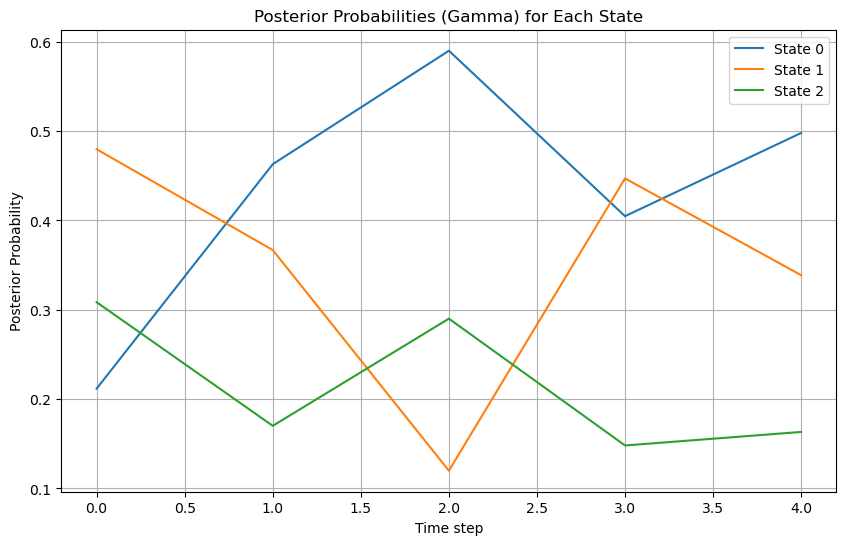

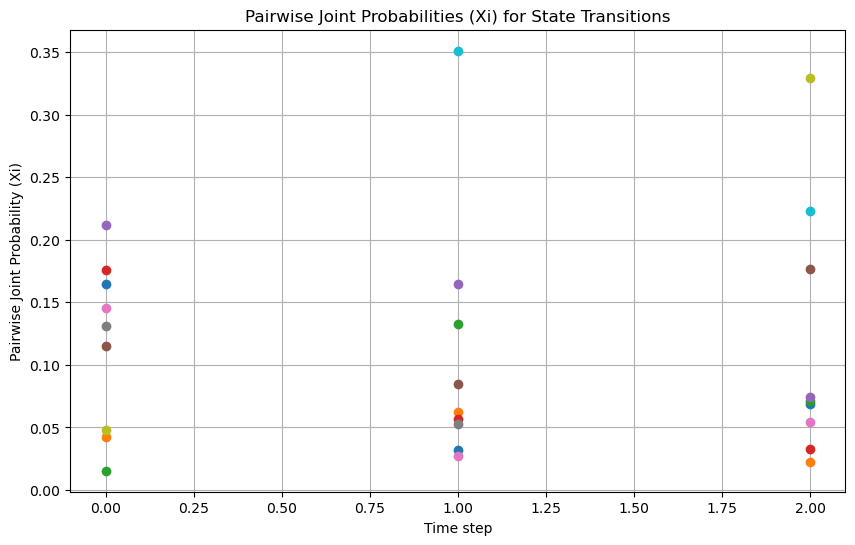

In [16]:
import matplotlib.pyplot as plt

def plot_gamma(gamma, states):
    """
    Plot the posterior probabilities (gamma) over time for each state.
    """
    N = len(gamma)  # Number of time steps
    K = len(states)  # Number of states
    
    plt.figure(figsize=(10, 6))
    
    # Plot each state's gamma (posterior probabilities) over time
    for k in range(K):
        plt.plot(range(N), [gamma[t][k] for t in range(N)], label=f'State {states[k]}')
    
    plt.xlabel('Time step')
    plt.ylabel('Posterior Probability')
    plt.title('Posterior Probabilities (Gamma) for Each State')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

def plot_xi(xi, states):
    """
    Plot the pairwise joint probabilities (xi) over time for each pair of states.
    """
    N = len(xi)  # Number of time steps
    K = len(states)  # Number of states
    
    # Plot pairwise transition probabilities for each time step
    plt.figure(figsize=(10, 6))
    for t in range(N - 1):  # We have N-1 transitions
        for i in range(K):
            for j in range(K):
                plt.plot(t, xi[t][i][j], 'o', label=f'Transition {states[i]} -> {states[j]}')
    
    plt.xlabel('Time step')
    plt.ylabel('Pairwise Joint Probability (Xi)')
    plt.title('Pairwise Joint Probabilities (Xi) for State Transitions')
    plt.grid(True)
    plt.show()

# Example usage with the previous results
# Assuming gamma and xi have been computed by the forward_backward function

# Plot gamma (posterior probabilities)
plot_gamma(gamma, states)

# Plot xi (pairwise joint probabilities)
plot_xi(xi, states)
